In [52]:
import numpy as np
import pickle
np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)
# import torch
from scipy.spatial.distance import cosine
from scipy.stats import multivariate_normal
from scipy.special import logsumexp
import csv
from tqdm import tqdm_notebook as tqdm
import itertools

In [2]:
# bert todos: load bert. save dictionary first of bert utterances. quds? nearest adjectives in glove space as per?

In [3]:
# 

In [4]:
# x: [BATCH w, DIM VECS]: vectors to be projected
# m: [DIM VECS, DIM PROJECTION SUBSPACE]. m is a single projection. each column vector in m is a line onto which one projects
def get_projection(m):
  covariance_matrix = np.dot(np.transpose(m),m)
  inverse_covariance_matrix = np.linalg.inv(covariance_matrix)
  #inverse_covariance_matrix = [DIM PROJECTION SUBSPACE, DIM PROJECTION SUBSPACE]
  
  def projection(x):
    #x: [DIM VECS, BATCH SIZE]
    #[DIM PROJECTION SUBSPACE, BATCH SIZE]
    uncorrected_projection_weights = np.dot(np.transpose(m),x.T)
    #[DIM PROJECTION SUBSPACE, BATCH SIZE]    
    projection_weights = np.dot(inverse_covariance_matrix,uncorrected_projection_weights)
    return np.dot(m,projection_weights).T
  
  return projection

In [6]:
# commenting scheme:
#   list(A) is a list of variables of type A
#   [x,y,z] is an array of shape (x,y,z)
  
#   DIM VECS = dimension of word embedding space
#   BATCH w = number of states w that are batched
#   NUM utts = number of utterances

In [33]:
# class contains several Bayesian pragmatic models:
# L0_Unbatched
# S1_Batched: fast S1, batched over w, and u (batch of u passed to L0): L0 is implicit in this S1
# S1_Unbatched: no batching: useful for understanding the code semantics clearly and for testing the batched version
# L1_Unbatched: no batched equivalent written
class Pragmatic_Model:
  # utterances : list(str). the utterance set U
  # projections : list(str). the projection set Q
  # vectors : dictionary: key:str,val:[dim vecs] of word embeddings
  # sigma1: hyperparameter for L0: variance of L0 prior. See paper
  # sigma2: hyperparameter for L0: variance of gaussian used in the semantics
  # mu1: hyperparameter for L0: the mean of the L0 prior: e.g. "man" in man is a shark. 
  def __init__(self,
              utterances,
              projections,
              vectors,
              sigma1,
              sigma2,
              mu1):
    
    self.utterances=utterances
    self.projections=projections
    # [NUM U, DIM VECS]
    self.utterance_vectors = np.asarray([vectors[u] for u in utterances]) 
    # [NUM Q, DIM VECS, DIM PROJECTION SUBSPACE]
    self.projection_vectors = (np.asarray([np.asarray([vectors[word]/np.linalg.norm(vectors[word]) for word in words]).T for words in self.projections]))
    self.vectors=vectors
    self.sigma1 = sigma1
    self.sigma2 = sigma2
    self.mu1 = mu1
    
    self.dimvecs = vectors["the"].shape[0]
    # how many dimensions does each projection have?
    self.dimsubspace = self.projection_vectors.shape[-1]
    
  # u : [DIM VECS]
  def L0_Unbatched(self,u):
    sigma1sq, sigma2sq = self.sigma1 ** 2, self.sigma2 ** 2
    mu = np.divide(np.add(self.mu1/sigma1sq, u/sigma2sq),  ((1/sigma1sq) + (1/sigma2sq)))
    sigma_base = ((1/sigma1sq) + (1/sigma2sq))**-1
    sigma = np.diag([sigma_base] * self.dimvecs)
    return mu,sigma
  
  # w : [1,DIM VECS]
  # q : [DIM VECS, DIM PROJECTION SUBSPACE]
  def S1_Unbatched(self,w,q):
    
    projection = get_projection(q)
    # calculates a term that decreases with the euclidean distance of q(w) to q(u) where q(x) is x projected onto the subspace spanned by q
    def utility(w,projection,u):
      l0_posterior_mu, l0_posterior_sigma = self.L0_Unbatched(u=u)
      projected_w = projection(w)
      projected_l0_posterior_mu = projection(l0_posterior_mu)
      log_score = multivariate_normal(projected_l0_posterior_mu,l0_posterior_sigma).logpdf(projected_w)
      return log_score
    
    unnormed_log_probs = [utility(w=w,projection=projection,u=u) for u in self.utterance_vectors]
    norm = logsumexp(unnormed_log_probs)
    return unnormed_log_probs - norm
  
  # ws: [BATCH w, DIM VECS]
  # q: [DIM VECS, DIM PROJECTION SUBSPACE]
  def S1_Batched(self, ws,q):

    projection = get_projection(q)

    # obtain L0 posterior MU and SIGMA
    sigma1sq, sigma2sq = self.sigma1 ** 2, self.sigma2 ** 2
    inverse_sd = (1/sigma1sq) + (1/sigma2sq)
    sigma = np.diag([1/inverse_sd] * self.dimvecs)
    inverse_sigma = np.linalg.inv(sigma)
    l0_posterior_mu = np.divide(np.add(self.mu1/sigma1sq, self.utterance_vectors/sigma2sq),inverse_sd)

    # projections
    # [NUM UTTS, DIM VECS]
    projected_l0_posterior_mu = projection(l0_posterior_mu)
#     print("BATCHED",projected_l0_posterior_mu)
    # [BATCH w, DIM VECS]
    projected_ws = projection(ws)
    
    # compute logprob of gaussian
    # [BATCH w, NUM UTTS, DIM VECS]
    distances = np.expand_dims(projected_ws,1)-np.expand_dims(projected_l0_posterior_mu,0)
    # [BATCH w, NUM UTTS, DIM VECS]
    rescaled_distances = np.einsum('ij,abi->abj',np.sqrt(inverse_sigma),distances)
    # [BATCH w, NUM UTTS]
    unnormed_logprobs = -0.5*np.sum(np.square(rescaled_distances),axis=2)
    # [BATCH w,1]
    norm = np.expand_dims(logsumexp(unnormed_logprobs,axis=-1),-1)
    # [BATCH w, NUM UTTS]
    return unnormed_logprobs-norm
  
  def L1(self,u):
    #u: [DIM VECS, 1]
    #listener_mean: [DIM VECS, 1]
    start = -5
    stop = 5.01
    step = 0.1
    # intervals: [NUM INTERVALS]    
    intervals = np.arange(start=start,stop=stop,step=step)
    num_intervals = int((stop-start)/step)
    
#     normal = multivariate_normal(mean=self.mu1, cov=[self.sigma1] * self.dimvecs)

    
    movement = {}
    marginal_projection_probs = np.zeros((len(self.projections)))
    for i in tqdm(range(len(self.projections))):
            
      q = self.projection_vectors[i]
      # assume q is a vector of unit length
      #q: [DIM VECS, 1]
      projection = get_projection(q)
      # [DIM VECS]
      projected_mu1 = projection(self.mu1)
      
      # [DIM VECS, NUM INTERVALS]
      projected_worlds = np.expand_dims(projected_mu1,0) + np.dot(q,np.expand_dims(intervals,0)).T

      # [NUM INTERVALS]
      speaker_log_likelihood = self.S1_Batched(projected_worlds,q)[:,u]
      
      # [NUM INTERVALS]
      world_log_priors = -1/(self.sigma1**2)*np.square(intervals)
      # TODO: draw from real gaussian and see if different
#       world_log_priors = np.asarray([normal.logpdf(i) for i in intervals])
      
      # [NUM INTERVALS]
      joint_probs = world_log_priors + speaker_log_likelihood
      left,right = np.exp(logsumexp(joint_probs[:num_intervals//2])), np.exp(logsumexp(joint_probs[1+num_intervals//2:]))
      movement[i]=right-left
      # SCALAR
      marginal_projection_prob = logsumexp(joint_probs)      
      marginal_projection_probs[i]=marginal_projection_prob
    
    norm = logsumexp(marginal_projection_probs)
    return marginal_projection_probs - norm, movement

  def L1_2D(self,u):
    #u: [DIM VECS, 1]
    #listener_mean: [DIM VECS, 1]
    start = -5
    stop = 5.1
    step = 0.5
    # intervals: [NUM INTERVALS]    
#     intervals = np.repeat(np.arange(start=start,stop=stop,step=step),self.dimsubspace)
#     intervals = intervals.reshape(2,intervals.shape[0]//2)
#     intervals = np.expand_dims(np.arange(start=start,stop=stop,step=step),0)
    intervals = np.arange(start=start,stop=stop,step=step)
#     intervals = np.stack([intervals]*self.dimsubspace)
    num_intervals = int((stop-start)/step)
    
    movement = {}
    marginal_projection_probs = np.zeros((len(self.projections)))
    for i in tqdm(range(len(self.projections))):
            
      q = self.projection_vectors[i]
      # assume q is a vector of unit length
      #q: [DIM VECS, 1]
      projection = get_projection(q)
      # [DIM VECS]
      projected_mu1 = projection(self.mu1)
      
      # [DIM VECS, NUM INTERVALS]
#       print(q[:,0,np.newaxis].shape)
      q0 = np.dot(q[:,0,np.newaxis],np.expand_dims(intervals,0))
      q1 = np.dot(q[:,1,np.newaxis],np.expand_dims(intervals,0))
#       q0 = q[:,0]*intervals
#       q1 = q[:,1]*intervals
      out = np.array([[q0[:,x]+q1[:,y]] for x in range(intervals.shape[0]) for y in range(intervals.shape[0])]).squeeze()
#       out = np.transpose([np.tile(x, len(y)), np.rep)eat(y, len(x))])
      print(q0.shape,q1.shape,out.shape)
#       print(out)
#       raise Exception
    
      projected_worlds = np.expand_dims(projected_mu1,0) + out

      # [NUM INTERVALS]
      speaker_log_likelihood = self.S1_Batched(projected_worlds,q)[:,u]
      
      # [NUM INTERVALS]
#       print(intervals.shape,np.array([[x,y] for x in intervals for y in intervals]).shape)
#       world_log_priors = -1/(self.sigma1**2)*np.square(np.ndarray.flatten(np.array([[x,y] for x in intervals for y in intervals])))
      world_log_priors = -1/(self.sigma1**2)*np.square(intervals)
      world_log_priors = np.ndarray.flatten(np.dot(np.expand_dims(world_log_priors,1),np.expand_dims(world_log_priors,0)))
      print(world_log_priors.shape)
      # [NUM INTERVALS]
      joint_probs = world_log_priors + speaker_log_likelihood
#       left,right = np.exp(logsumexp(joint_probs[:num_intervals//2])), np.exp(logsumexp(joint_probs[1+num_intervals//2:]))
#       movement[i]=right-left
      # SCALAR
      marginal_projection_prob = logsumexp(joint_probs)      
      marginal_projection_probs[i]=marginal_projection_prob
     
    norm = logsumexp(marginal_projection_probs)
    return marginal_projection_probs - norm, movement

In [8]:
simple_utterances = ["man","shark","swimmer"]
# ,"wonder"]
simple_projections = [["swims","vicious"],["vicious","nightmare"]]
# simple_projections = [["swims"],["vicious"],["nightmare"]]

simple_vecs = {}
simple_vecs["swimmer"]=np.asarray([0.0,1.0])
simple_vecs["shark"]=np.asarray([1.0,1.0])
simple_vecs["man"]=np.asarray([0.0,0.0])
simple_vecs["vicious"]=np.asarray([1.0,0.0])
simple_vecs["swims"]=np.asarray([0.0,1.0])
simple_vecs["the"]=np.asarray([0.0,0.0])
simple_vecs["child"]=np.asarray([0.1,-1.0])
simple_vecs["nightmare"]=np.asarray([1.0,1.0])
simple_vecs["wonder"]=np.asarray([1.0,-1.0])

simple_mu1 = simple_vecs["man"]

In [9]:
simple_model = Pragmatic_Model(utterances=simple_utterances,
                                  projections=simple_projections,
                                  vectors=simple_vecs,
                                 sigma1=5.0,
                                 sigma2=0.5,
                                 mu1=simple_mu1)

In [10]:
# raw_output, movement = simple_model.L1(u=1)
raw_output, movement = simple_model.L1_2D(u=0)

100%|██████████| 2/2 [00:00<00:00,  9.05it/s]

(2, 101) (2, 101) (10201, 2)
(10201,)
(2, 101) (2, 101) (10201, 2)
(10201,)


In [11]:


results = sorted(list(zip(np.exp(raw_output),simple_projections)),key=lambda x: x[0],reverse=True)

for i,(prob,q) in enumerate(results):
    print(prob,q)
    if i > 20: break

0.5179756702730719 ['vicious', 'nightmare']
0.4820243297269279 ['swims', 'vicious']


In [49]:
out = simple_model.S1_Batched(np.array([simple_vecs["shark"]]),q=np.array([simple_vecs["nightmare"]]).T).squeeze()
print(list(zip(simple_utterances,np.exp(out))))


[('man', 0.012805862724697095), ('shark', 0.7274222000587304), ('swimmer', 0.25977193721657243)]


In [200]:
test_utterances = ["shark","swimmer","wonder","child"]
test_projections = [["swims"],["vicious"],["man"]]
test_mu1 = np.random.rand(5)
test_ws = np.random.rand(10,5)

test_vecs = {}
test_vecs["swimmer"]=np.random.rand(5)
test_vecs["shark"]=np.random.rand(5)
test_vecs["man"]=np.random.rand(5)
test_vecs["vicious"]=np.random.rand(5)
test_vecs["swims"]=np.random.rand(5)
test_vecs["child"]=np.random.rand(5)
test_vecs["nightmare"]=np.random.rand(5)
test_vecs["wonder"]=np.random.rand(5)
test_vecs["the"]=np.random.rand(5)

test_model = Pragmatic_Model(utterances=test_utterances,
                                  projections=test_projections,
                                  vectors=test_vecs,
                                 sigma1=1.0,
                                 sigma2=2.0,
                                 mu1=test_mu1)

0.33373021266959213 ['swims'] -23.495606630748796
0.3336409106174595 ['vicious'] -19.856699436855706
0.33262887671294833 ['man'] -11.031278492257343


In [96]:
#test that S1_Batched and S1_Unbatched are equivalent, up to numerical precision
q = test_model.projection_vectors[0]
batched = test_model.S1_Batched(ws=test_ws,q=q)

for i,w in enumerate(test_ws):
  unbatched = test_model.S1_Unbatched(w=test_ws[i],q=q)
  b = batched[i]
  ub = unbatched
  print(b,ub)
  assert(np.allclose(b,ub))


[-1.393 -1.379 -1.384 -1.389] [-1.393 -1.379 -1.384 -1.389]
[-1.387 -1.385 -1.386 -1.387] [-1.387 -1.385 -1.386 -1.387]
[-1.391 -1.381 -1.385 -1.388] [-1.391 -1.381 -1.385 -1.388]
[-1.379 -1.394 -1.389 -1.383] [-1.379 -1.394 -1.389 -1.383]
[-1.383 -1.391 -1.388 -1.384] [-1.383 -1.391 -1.388 -1.384]
[-1.398 -1.373 -1.382 -1.392] [-1.398 -1.373 -1.382 -1.392]
[-1.395 -1.376 -1.383 -1.39 ] [-1.395 -1.376 -1.383 -1.39 ]
[-1.379 -1.395 -1.389 -1.383] [-1.379 -1.395 -1.389 -1.383]
[-1.392 -1.381 -1.384 -1.389] [-1.392 -1.381 -1.384 -1.389]
[-1.393 -1.379 -1.384 -1.389] [-1.393 -1.379 -1.384 -1.389]


In [190]:
# test that batched projection is equivalent to unbatched projection
m = np.random.rand(10,3)
x = np.random.rand(2,10)

projection = get_projection(m)
projected_x = projection(x)
assert(np.allclose(projection(x)[0],projection(x[0])))
assert(np.allclose(projection(x)[1],projection(x[1])))

In [40]:
# pickled version of GLoVE
# vecs = pickle.load(open("/Users/reuben/Downloads/glove.840B.plain300",'rb'))
vecs = pickle.load(open("/Users/reuben/Downloads/glove.twitter.27B.plain25",'rb'))

def get_words(with_freqs=False):
	nouns, adjs, words = {},{},set()
	with open('../dist_rsa/data/concreteness.csv', newline='') as csvfile:
		r = csv.reader(csvfile, delimiter=',', quotechar='|')
		for i,row in enumerate(r):
			if i>0:
				is_bigram = float(row[1])!=0
				is_noun = (row[8])=='Noun'		
				is_adj = (row[8])=='Adjective'
				is_adv = (row[8])=='Adverb'
				freq = row[7]
				if not is_bigram:
					if is_noun:
						if with_freqs:nouns[row[0]]=float(row[2]),freq
						else: nouns[row[0]]=float(row[2])
					if is_adj:
						if with_freqs: adjs[row[0]]=float(row[2]),freq
						else: adjs[row[0]]=float(row[2])
		return nouns,adjs

In [57]:
abstract_threshold = 2.5
concrete_threshold = 3.0

target = "man"
source = "shark"

nouns,adjs = get_words(with_freqs=False)
nouns = [noun for noun in nouns if noun in vecs]
adjectives = [a for a in adjs if adjs[a] > concrete_threshold and a in vecs]
utterances = sorted(nouns,key=lambda x: cosine(vecs[x],vecs[target]))
projections = [a for a in adjs if adjs[a] < abstract_threshold and a in vecs]
projections = sorted(projections,key=lambda x:cosine(vecs[x],vecs[target]))
projections = [[x] for x in projections]

if source in utterances: utterances.remove(source)
if target in utterances: utterances.remove(target)

utterances = [source]+utterances[:500]
projections = projections[:500]

# projections = [["unstable"],["vicious"]]

pragmatic_model = Pragmatic_Model(utterances=utterances,
                                  projections=projections,
                                  vectors=vecs,
                                 sigma1=10.0,
                                 sigma2=0.1,
                                 mu1=vecs[target])


In [58]:
raw_output, movement = pragmatic_model.L1(u=0)

In [59]:
print("baseline",projections[:10])
print("utterance",pragmatic_model.utterances[0])
results = sorted(list(zip(np.exp(raw_output),projections)),key=lambda x: x[0],reverse=True)

for i,(prob,q) in enumerate(results):
    print(prob,q,movement[pragmatic_model.projections.index(q)])
    if i > 20: break
# print(movement[pragmatic_model.projections.index(["pure"])])


baseline [['bad'], ['glad'], ['sure'], ['damn'], ['sorry'], ['true'], ['crazy'], ['wrong'], ['nice'], ['best']]
utterance shark
0.18019593030586262 ['normal'] -12.752411518797636
0.06630693289388034 ['humble'] -4.692521597889556
0.05005289576870094 ['sorry'] -3.5422283037498357
0.028125752648599536 ['moral'] -1.9904510131946338
0.012885603492530734 ['important'] -0.9119102641546273
0.011328387789515972 ['mutual'] -0.80170657956158
0.0100766239422366 ['supportive'] -0.7131196304680876
0.009636166729778179 ['positive'] -0.6819486066821553
0.008230399998731906 ['simple'] -0.5824629200558923
0.007318009560224657 ['legal'] -0.5178933245166855
0.007148735170450717 ['keen'] -0.5059138271200098
0.006198568830310779 ['busy'] -0.43867084244101506
0.005989368232884126 ['interested'] -0.4238657793975007
0.005950943100232249 ['sensible'] -0.42114644437473203
0.005673715984604799 ['honest'] -0.4015271652009474
0.0050109038639382765 ['particular'] -0.3546201517737334
0.004799850675266956 ['glad'] -0.

In [36]:
print("baseline",projections[:10])
print("utterance",pragmatic_model.utterances[0])
results = sorted(list(zip(np.exp(raw_output),projections)),key=lambda x: x[0],reverse=True)

for i,(prob,q) in enumerate(results):
    print(prob,q,movement[pragmatic_model.projections.index(q)])
    if i > 20: break
# print(movement[pragmatic_model.projections.index(["pure"])])


baseline [['vanquished'], ['unambiguous'], ['fresh'], ['wild'], ['delicious'], ['plentiful'], ['exotic'], ['good'], ['smaller'], ['nutritious']]
utterance shark
0.061142378607337296 ['prehistoric'] 0.2679338832992011
0.04039511887938222 ['sacramental'] 0.35781296757833664
0.03715801237377391 ['dangerous'] -0.3264055251997479
0.035779076980152424 ['elusive'] 0.021992331479576174
0.027546772540760375 ['spectacular'] -0.24381562439321378
0.02672404398927931 ['super'] 0.1272729561475605
0.026098184177677668 ['rare'] -0.23106027998616246
0.025844215926119376 ['nautical'] -0.22883334214447562
0.02424836018076418 ['unfailing'] -0.211182787722992
0.02298610424344559 ['crazy'] -0.18722713214998854
0.02265762389152906 ['presumptuous'] -0.2006967793741075
0.02104449128069598 ['weird'] -0.1771726436770905
0.01798012984260194 ['invasive'] -0.1592630552556697
0.01752628511092265 ['incredible'] -0.1544080039267802
0.01734046469812969 ['damn'] -0.15343062731676177
0.01729862431313564 ['homing'] -0.152

In [32]:
print("baseline",projections[:10])
print("utterance",pragmatic_model.utterances[0])
results = sorted(list(zip(np.exp(raw_output),projections)),key=lambda x: x[0],reverse=True)

for i,(prob,q) in enumerate(results):
    print(prob,q,movement[pragmatic_model.projections.index(q)])
    if i > 20: break
# print(movement[pragmatic_model.projections.index(["pure"])])


baseline [['good'], ['wrong'], ['true'], ['strange'], ['lucky'], ['bad'], ['great'], ['guilty'], ['brave'], ['innocent']]
utterance shark
0.10075042308194951 ['wild'] 0.6744023235258155
0.03487957369153994 ['worse'] -0.26408625734087254
0.022923285283942687 ['eager'] -0.17356073987973825
0.020866933611245156 ['amazing'] -0.1579913346475116
0.020435308132146845 ['arrogant'] -0.1547233372159914
0.01994421777405727 ['sorry'] -0.151005109010825
0.01973209706821721 ['worried'] -0.14939906405725842
0.01882532987458157 ['fake'] -0.14221710822119174
0.018600195386382988 ['supposed'] -0.14082901439217618
0.018427785377330787 ['insane'] -0.1395236339302084
0.01790727996099102 ['jealous'] -0.13558269335156362
0.017898466967404596 ['dangerous'] -0.13544178313642904
0.016985174678854135 ['terrible'] -0.12860109045161633
0.015907295099369567 ['silly'] -0.12044006226538201
0.015642759087798892 ['obsessed'] -0.1184371612515394
0.015591620475810499 ['cruel'] -0.11804997199076445
0.015300118118121086 ['

In [24]:
raw_output, movement = pragmatic_model.L1(u=0)


100%|██████████| 50/50 [00:34<00:00,  1.54it/s]

In [25]:
print("baseline",projections[:10])
print("utterance",pragmatic_model.utterances[0])
results = sorted(list(zip(np.exp(raw_output),projections)),key=lambda x: x[0],reverse=True)

for i,(prob,q) in enumerate(results):
    print(prob,q,movement[pragmatic_model.projections.index(q)])
    if i > 20: break
# print(movement[pragmatic_model.projections.index(["pure"])])


baseline [['alternating'], ['astrological'], ['bearish'], ['boastful'], ['consecutive'], ['continental'], ['demographic'], ['disjointed'], ['distinguishable'], ['disturbing']]
utterance river
0.1560474780865443 ['sullen'] -6.832875473065822
0.13340108235415957 ['sleazy'] -5.85769089668664
0.10936799893076164 ['matriarchal'] -4.606556682890845
0.10261266310513917 ['continental'] 4.505785688711545
0.08299353455971968 ['studious'] 3.644297584320696
0.07042042467081353 ['disturbing'] -3.0922045298453753
0.04142030615907694 ['literate'] -1.8187910947948736
0.028364110798092323 ['hardworking'] -1.2454856997141148
0.027413246891679705 ['alternating'] 0.43974647249805887
0.023936121464454486 ['boastful'] 1.0510499413439234
0.017718297002522865 ['womanly'] -0.7775579701678605
0.015682312859493498 ['pushy'] -0.6885631442302297
0.012379036872685954 ['unattached'] 0.5435711879325296
0.011354351638213907 ['visionary'] -0.4919973246401441
0.010730180157103343 ['yappy'] 0.4623205324474608
0.009620532

In [20]:
# 2D CASE

abstract_threshold = 2.5
concrete_threshold = 3.0

target = "man"
source = "shark"

nouns,adjs = get_words(with_freqs=False)
nouns = [noun for noun in nouns if noun in vecs]
adjectives = [adjective for adjective in adjectives if adjective in vecs]
adjectives = [a for a in adjs if adjs[a] > concrete_threshold and a in vecs]
utterances = sorted(nouns,key=lambda x: cosine(vecs[x],vecs[target]))
projections = [a for a in adjs if adjs[a] < abstract_threshold and a in vecs]
projections = sorted(projections,key=lambda x:cosine(vecs[x],vecs[target]))
# projections = [[x] for x in projections]

if source in utterances: utterances.remove(source)
if target in utterances: utterances.remove(target)

utterances = [source]+utterances[:50]
projections = projections[:10]
projections = [[x,y] for (x,y) in itertools.product(projections,projections) if x!=y and x>y]

pragmatic_model = Pragmatic_Model(utterances=utterances,
                                  projections=projections,
                                  vectors=vecs,
                                 sigma1=1.0,
                                 sigma2=0.1,
                                 mu1=vecs[target])


In [21]:
raw_output, movement = pragmatic_model.L1_2D(u=0)


  0%|          | 0/45 [00:00<?, ?it/s]

(300, 21) (300, 21) (441, 300)



  2%|▏         | 1/45 [00:02<02:11,  2.99s/it]

(441,)
(300, 21) (300, 21) (441, 300)



  4%|▍         | 2/45 [00:05<02:08,  2.99s/it]

(441,)
(300, 21) (300, 21) (441, 300)



  7%|▋         | 3/45 [00:08<02:01,  2.89s/it]

(441,)
(300, 21) (300, 21) (441, 300)



  9%|▉         | 4/45 [00:11<01:55,  2.82s/it]

(441,)
(300, 21) (300, 21) (441, 300)



 11%|█         | 5/45 [00:13<01:50,  2.77s/it]

(441,)
(300, 21) (300, 21) (441, 300)



 13%|█▎        | 6/45 [00:17<01:51,  2.86s/it]

(441,)
(300, 21) (300, 21) (441, 300)



 16%|█▌        | 7/45 [00:20<01:55,  3.04s/it]

(441,)
(300, 21) (300, 21) (441, 300)



 18%|█▊        | 8/45 [00:23<01:55,  3.12s/it]

(441,)
(300, 21) (300, 21) (441, 300)



 20%|██        | 9/45 [00:27<02:02,  3.41s/it]

(441,)
(300, 21) (300, 21) (441, 300)



 22%|██▏       | 10/45 [00:32<02:14,  3.85s/it]

(441,)
(300, 21) (300, 21) (441, 300)



 24%|██▍       | 11/45 [00:36<02:12,  3.89s/it]

(441,)
(300, 21) (300, 21) (441, 300)



 27%|██▋       | 12/45 [00:43<02:41,  4.90s/it]

(441,)
(300, 21) (300, 21) (441, 300)



 29%|██▉       | 13/45 [00:47<02:25,  4.55s/it]

(441,)
(300, 21) (300, 21) (441, 300)



 31%|███       | 14/45 [00:50<02:06,  4.09s/it]

(441,)
(300, 21) (300, 21) (441, 300)



 33%|███▎      | 15/45 [00:54<01:57,  3.92s/it]

(441,)
(300, 21) (300, 21) (441, 300)



 36%|███▌      | 16/45 [00:57<01:47,  3.70s/it]

(441,)
(300, 21) (300, 21) (441, 300)



 38%|███▊      | 17/45 [01:00<01:41,  3.64s/it]

(441,)
(300, 21) (300, 21) (441, 300)



 40%|████      | 18/45 [01:03<01:33,  3.46s/it]

(441,)
(300, 21) (300, 21) (441, 300)



 42%|████▏     | 19/45 [01:07<01:27,  3.36s/it]

(441,)
(300, 21) (300, 21) (441, 300)



 44%|████▍     | 20/45 [01:10<01:22,  3.31s/it]

(441,)
(300, 21) (300, 21) (441, 300)



 47%|████▋     | 21/45 [01:13<01:16,  3.19s/it]

(441,)
(300, 21) (300, 21) (441, 300)



 49%|████▉     | 22/45 [01:15<01:09,  3.04s/it]

(441,)
(300, 21) (300, 21) (441, 300)



 51%|█████     | 23/45 [01:18<01:04,  2.94s/it]

(441,)
(300, 21) (300, 21) (441, 300)



 53%|█████▎    | 24/45 [01:21<00:59,  2.81s/it]

(441,)
(300, 21) (300, 21) (441, 300)



 56%|█████▌    | 25/45 [01:23<00:54,  2.73s/it]

(441,)
(300, 21) (300, 21) (441, 300)



 58%|█████▊    | 26/45 [01:26<00:50,  2.63s/it]

(441,)
(300, 21) (300, 21) (441, 300)



 60%|██████    | 27/45 [01:28<00:46,  2.60s/it]

(441,)
(300, 21) (300, 21) (441, 300)



 62%|██████▏   | 28/45 [01:31<00:44,  2.64s/it]

(441,)
(300, 21) (300, 21) (441, 300)



 64%|██████▍   | 29/45 [01:34<00:43,  2.74s/it]

(441,)
(300, 21) (300, 21) (441, 300)



 67%|██████▋   | 30/45 [01:36<00:39,  2.66s/it]

(441,)
(300, 21) (300, 21) (441, 300)



 69%|██████▉   | 31/45 [01:39<00:36,  2.63s/it]

(441,)
(300, 21) (300, 21) (441, 300)



 71%|███████   | 32/45 [01:41<00:33,  2.60s/it]

(441,)
(300, 21) (300, 21) (441, 300)



 73%|███████▎  | 33/45 [01:44<00:30,  2.55s/it]

(441,)
(300, 21) (300, 21) (441, 300)



 76%|███████▌  | 34/45 [01:46<00:27,  2.52s/it]

(441,)
(300, 21) (300, 21) (441, 300)



 78%|███████▊  | 35/45 [01:49<00:25,  2.58s/it]

(441,)
(300, 21) (300, 21) (441, 300)



 80%|████████  | 36/45 [01:52<00:23,  2.59s/it]

(441,)
(300, 21) (300, 21) (441, 300)



 82%|████████▏ | 37/45 [01:54<00:20,  2.55s/it]

(441,)
(300, 21) (300, 21) (441, 300)



 84%|████████▍ | 38/45 [01:56<00:17,  2.50s/it]

(441,)
(300, 21) (300, 21) (441, 300)



 87%|████████▋ | 39/45 [01:59<00:14,  2.46s/it]

(441,)
(300, 21) (300, 21) (441, 300)



 89%|████████▉ | 40/45 [02:01<00:12,  2.51s/it]

(441,)
(300, 21) (300, 21) (441, 300)



 91%|█████████ | 41/45 [02:04<00:10,  2.56s/it]

(441,)
(300, 21) (300, 21) (441, 300)



 93%|█████████▎| 42/45 [02:07<00:07,  2.52s/it]

(441,)
(300, 21) (300, 21) (441, 300)



 96%|█████████▌| 43/45 [02:09<00:04,  2.49s/it]

(441,)
(300, 21) (300, 21) (441, 300)



 98%|█████████▊| 44/45 [02:12<00:02,  2.62s/it]

(441,)
(300, 21) (300, 21) (441, 300)



100%|██████████| 45/45 [02:15<00:00,  2.67s/it]

(441,)


In [22]:
print("baseline",projections[:10])
print("utterance",pragmatic_model.utterances[0])
results = sorted(list(zip(np.exp(raw_output),projections)),key=lambda x: x[0],reverse=True)

for i,(prob,q) in enumerate(results):
    print(prob,q)
    if i > 20: break
# print(movement[pragmatic_model.projections.index(["pure"])])


baseline [['good', 'bad'], ['good', 'brave'], ['wrong', 'good'], ['wrong', 'true'], ['wrong', 'strange'], ['wrong', 'lucky'], ['wrong', 'bad'], ['wrong', 'great'], ['wrong', 'guilty'], ['wrong', 'brave']]
utterance shark
0.039643934271529874 ['good', 'brave']
0.039643934271529874 ['wrong', 'good']
0.039643934271529874 ['wrong', 'strange']
0.039643934271529874 ['wrong', 'guilty']
0.039643934271529874 ['wrong', 'brave']
0.039643934271529874 ['wrong', 'innocent']
0.039643934271529874 ['true', 'guilty']
0.039643934271529874 ['true', 'brave']
0.039643934271529874 ['true', 'innocent']
0.039643934271529874 ['strange', 'guilty']
0.039643934271529874 ['strange', 'innocent']
0.039643934271529874 ['lucky', 'innocent']
0.039643934271529874 ['great', 'brave']
0.039643934271529874 ['guilty', 'good']
0.039643934271529874 ['guilty', 'bad']
0.039643934271529874 ['guilty', 'great']
0.039643934271529874 ['brave', 'bad']
0.039643934271529874 ['innocent', 'good']
0.039643934271529874 ['innocent', 'bad']
0.

AttributeError: 'BarContainer' object has no attribute 'figure'

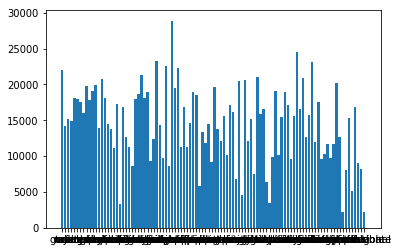

In [97]:
import matplotlib
from matplotlib import pyplot

_, projs = list(zip(*results))
projs = list(projections)
movements = [movement[pragmatic_model.projections.index(i)] for i in projs]
projs = [i[0] for i in projs]
plt = matplotlib.pyplot.bar(projs, movements)
plt.figure(figsize=(20,10))

In [ ]:
# class contains Bayesian models for CONTEXTUALIZED word vectors
# S1: fast S1, batched over w, and u (batch of u passed to L0): L0 is implicit in this S1
# L1
class Contextualized_Pragmatic_Model:
  # utterances : list(str). the utterance set U
  # projections : list(str). the projection set Q
  # vectors : dictionary: key:str,val:[dim vecs] of word embeddings
  # sigma1: hyperparameter for L0: variance of L0 posterior
  # sigma2: hyperparameter for L1: variance of L1 prior. See paper
  # mu2: hyperparameter for L1: the mean of the L1 prior: e.g. "the man is" in man is a shark. 
  def __init__(self,
              utterances,
              projections,
              vectors,
              sigma1,
              sigma2,
              mu2):
    
    self.utterances=utterances
    self.projections=projections
    # [NUM U, DIM VECS]
    self.utterance_vectors = np.asarray([vectors[u] for u in utterances]) 
    # [NUM Q, DIM VECS, DIM PROJECTION SUBSPACE]
    self.projection_vectors = (np.asarray([np.asarray([vectors[word]/np.linalg.norm(vectors[word]) for word in words]).T for words in self.projections]))
    self.vectors=vectors
    self.sigma1 = sigma1
    self.sigma2 = sigma2
    self.mu2 = mu2
    
    self.dimvecs = vectors["the"].shape[0]
    # how many dimensions does each projection have?
    self.dimsubspace = self.projection_vectors.shape[-1]
    
  # u : [DIM VECS]
  def L0_Unbatched(self,u):
    return self.vecs[u], self.sigma1
  
  # w : [1,DIM VECS]
  # q : [DIM VECS, DIM PROJECTION SUBSPACE]
  def S1_Unbatched(self,w,q):
    
    projection = get_projection(q)
    # calculates a term that decreases with the euclidean distance of q(w) to q(u) where q(x) is x projected onto the subspace spanned by q
    def utility(w,projection,u):
      l0_posterior_mu, l0_posterior_sigma = self.L0_Unbatched(u=u)
      projected_w = projection(w)
      projected_l0_posterior_mu = projection(l0_posterior_mu)
      log_score = multivariate_normal(projected_l0_posterior_mu,l0_posterior_sigma).logpdf(projected_w)
      return log_score
    
    unnormed_log_probs = [utility(w=w,projection=projection,u=u) for u in self.utterance_vectors]
    norm = logsumexp(unnormed_log_probs)
    return unnormed_log_probs - norm
  
  # ws: [BATCH w, DIM VECS]
  # q: [DIM VECS, DIM PROJECTION SUBSPACE]
  def S1_Batched(self, ws,q):

    projection = get_projection(q)

    # obtain L0 posterior MU and SIGMA
    sigma1sq, sigma2sq = self.sigma1 ** 2, self.sigma2 ** 2
    inverse_sd = (1/sigma1sq) + (1/sigma2sq)
    sigma = np.diag([1/inverse_sd] * self.dimvecs)
    inverse_sigma = np.linalg.inv(sigma)
    l0_posterior_mu = np.divide(np.add(self.mu1/sigma1sq, self.utterance_vectors/sigma2sq),inverse_sd)

    # projections
    # [NUM UTTS, DIM VECS]
    projected_l0_posterior_mu = projection(l0_posterior_mu)
#     print("BATCHED",projected_l0_posterior_mu)
    # [BATCH w, DIM VECS]
    projected_ws = projection(ws)
    
    # compute logprob of gaussian
    # [BATCH w, NUM UTTS, DIM VECS]
    distances = np.expand_dims(projected_ws,1)-np.expand_dims(projected_l0_posterior_mu,0)
    # [BATCH w, NUM UTTS, DIM VECS]
    rescaled_distances = np.einsum('ij,abi->abj',np.sqrt(inverse_sigma),distances)
    # [BATCH w, NUM UTTS]
    unnormed_logprobs = -0.5*np.sum(np.square(rescaled_distances),axis=2)
    # [BATCH w,1]
    norm = np.expand_dims(logsumexp(unnormed_logprobs,axis=-1),-1)
    # [BATCH w, NUM UTTS]
    return unnormed_logprobs-norm
  
  def L1(self,u):
    #u: [DIM VECS, 1]
    #listener_mean: [DIM VECS, 1]
    start = -5
    stop = 5.01
    step = 0.1
    # intervals: [NUM INTERVALS]    
    intervals = np.arange(start=start,stop=stop,step=step)
    num_intervals = int((stop-start)/step)
    
#     normal = multivariate_normal(mean=self.mu1, cov=[self.sigma1] * self.dimvecs)

    
    movement = {}
    marginal_projection_probs = np.zeros((len(self.projections)))
    for i in tqdm(range(len(self.projections))):
            
      q = self.projection_vectors[i]
      # assume q is a vector of unit length
      #q: [DIM VECS, 1]
      projection = get_projection(q)
      # [DIM VECS]
      projected_mu1 = projection(self.mu1)
      
      # [DIM VECS, NUM INTERVALS]
      projected_worlds = np.expand_dims(projected_mu1,0) + np.dot(q,np.expand_dims(intervals,0)).T

      # [NUM INTERVALS]
      speaker_log_likelihood = self.S1_Batched(projected_worlds,q)[:,u]
      
      # [NUM INTERVALS]
      world_log_priors = -1/(self.sigma1**2)*np.square(intervals)
      # TODO: draw from real gaussian and see if different
#       world_log_priors = np.asarray([normal.logpdf(i) for i in intervals])
      
      # [NUM INTERVALS]
      joint_probs = world_log_priors + speaker_log_likelihood
      left,right = np.exp(logsumexp(joint_probs[:num_intervals//2])), np.exp(logsumexp(joint_probs[1+num_intervals//2:]))
      movement[i]=right-left
      # SCALAR
      marginal_projection_prob = logsumexp(joint_probs)      
      marginal_projection_probs[i]=marginal_projection_prob
    
    norm = logsumexp(marginal_projection_probs)
    return marginal_projection_probs - norm, movement

In [61]:
import torch
from pytorch_pretrained_bert import TransfoXLTokenizer, TransfoXLModel, TransfoXLLMHeadModel

# OPTIONAL: if you want to have more information on what's happening, activate the logger as follows
import logging
logging.basicConfig(level=logging.INFO)

model = TransfoXLModel.from_pretrained('transfo-xl-wt103')
model.eval()

# Load pre-trained model tokenizer (vocabulary from wikitext 103)
tokenizer = TransfoXLTokenizer.from_pretrained('transfo-xl-wt103')

model = TransfoXLLMHeadModel.from_pretrained('transfo-xl-wt103')
model.eval()




  0%|          | 0/9143613 [00:00<?, ?B/s]

 11%|█         | 1027072/9143613 [00:00<00:00, 10262704.22B/s]

 28%|██▊       | 2576384/9143613 [00:00<00:00, 11419003.91B/s]

 46%|████▌     | 4212736/9143613 [00:00<00:00, 12552672.06B/s]

 62%|██████▏   | 5665792/9143613 [00:00<00:00, 13076179.64B/s]

 74%|███████▍  | 6776832/9143613 [00:00<00:00, 9676817.70B/s] 

 90%|█████████ | 8267776/9143613 [00:00<00:00, 10815312.51B/s]

100%|██████████| 9143613/9143613 [00:00<00:00, 12529065.16B/s]

projections

In [112]:
# Load pre-trained model (weights)

def text_to_bertspace(text):
    # text_1 = "The man is a"
    tokenized_text_1 = tokenizer.tokenize(text)
    indexed_tokens_1 = tokenizer.convert_tokens_to_ids(tokenized_text_1)
    tokens_tensor_1 = torch.tensor([indexed_tokens_1])
    # If you have a GPU, put everything on cuda
    # tokens_tensor_1 = tokens_tensor_1.to('cuda')
    # tokens_tensor_2 = tokens_tensor_2.to('cuda')
    # model.to('cuda')

    with torch.no_grad():
        # Predict hidden states features for each layer
        hidden_states_1, mems_1 = model(tokens_tensor_1)
        # We can re-use the memory cells in a subsequent call to attend a longer context
    #     hidden_states_2, mems_2 = model(tokens_tensor_2, mems=mems_1)
    return hidden_states_1.numpy()[0][-1]

In [85]:
# Load pre-trained model (weights)


# If you have a GPU, put everything on cuda
# tokens_tensor_1 = tokens_tensor_1.to('cuda')
# tokens_tensor_2 = tokens_tensor_2.to('cuda')
# model.to('cuda')
# p(u|c)
def text_to_prediction(text):
    tokenized_text_1 = tokenizer.tokenize(text)
    indexed_tokens_1 = tokenizer.convert_tokens_to_ids(tokenized_text_1)
    tokens_tensor_1 = torch.tensor([indexed_tokens_1])

    with torch.no_grad():
        predictions_1, mems_1 = model(tokens_tensor_1)
    
    return predictions_1[0, -1, :].numpy()

#     predicted_index = torch.argmax(predictions_1[0, -1, :]).item()
#     predicted_token = tokenizer.convert_ids_to_tokens([predicted_index])[0]


In [86]:
text_to_prediction(target)

torch.Size([1, 4, 1024])


array([-0.017,  0.137, -0.017, ..., -0.182, -0.042,  0.149], dtype=float32)

In [113]:
# todos:
# simple version: bert utterances, bert mu, bert quds
# bert api functions: list to dist(next), list to hidden
# new l0
# geometry test: "(the man is a) shark" along "vicious" vs "(the man is a) fish" along vicious2
# create appropriate bert vectors: for the target phrase, for each target+utt l0 posterior dist, 
# 

bert_vecs = {}

target = "man"
source = "shark"

mu1 = text_to_bertspace(target)

# abstract_threshold = 2.5
# # concrete_threshold = 3.0

# # nouns,adjs = get_words(with_freqs=False)
# # nouns = [noun for noun in nouns if noun in vecs]

utterances = ["shark","swimmer","man"]
projections = [["swims"],["vicious"]]

# utterance_vecs = to_bert(target+" "+source)
for i,u in enumerate(utterances):
    bert_vecs[u]=text_to_bertspace(target+" "+u)
    
for q in projections:
    bert_vecs[q[0]]=text_to_bertspace(q[0])
#     bert_vecs[full utterance string]=utterance_vecs[i]

bert_vecs["the"]=np.zeros(1024)
# projection_vecs = 


# adjectives = [a for a in adjs if adjs[a] > concrete_threshold and a in vecs]
# projections = [a for a in adjs if adjs[a] < abstract_threshold and a in vecs]
# projections = sorted(projections,key=lambda x:cosine(vecs[x],vecs[target]))
# projections = [[x] for x in projections]

# if source in utterances: utterances.remove(source)
# utterances = [source]+utterances[:500]
# projections = projections[:500]

# # projections = [["unstable"],["vicious"]]

pragmatic_model = Pragmatic_Model(utterances=utterances,
                                  projections=projections,
                                  vectors=bert_vecs,
                                 sigma1=1.0,
                                 sigma2=1.0,
                                 mu1=mu1)


In [114]:
print(bert_vecs["man"])
print(bert_vecs["shark"])

[ 0.16  -0.031 -0.127 ... -0.35  -0.224 -0.12 ]
[-0.096 -0.08   0.113 ... -0.227 -0.154  0.007]


In [115]:
raw_output, movement = pragmatic_model.L1(u=0)
print("baseline",projections[:10])
print("utterance",pragmatic_model.utterances[0])
results = sorted(list(zip(np.exp(raw_output),projections)),key=lambda x: x[0],reverse=True)

for i,(prob,q) in enumerate(results):
    print(prob,q,movement[pragmatic_model.projections.index(q)])
    if i > 20: break
# print(movement[pragmatic_model.projections.index(["pure"])])


baseline [['swims'], ['vicious']]
utterance shark
0.502724895061009 ['swims'] 0.46782541688967294
0.497275104938991 ['vicious'] 1.0875008543620663
